Epoch [1/200] - Time: 2.30s
Train Loss: 7.6561, Train Acc: 0.38%
Val Loss: 7.0500, Val Acc: 6.86%
--------------------------------------------------
Epoch [2/200] - Time: 2.00s
Train Loss: 7.2458, Train Acc: 6.24%
Val Loss: 6.7948, Val Acc: 16.45%
--------------------------------------------------
Epoch [3/200] - Time: 2.02s
Train Loss: 6.8198, Train Acc: 17.23%
Val Loss: 6.3885, Val Acc: 28.00%
--------------------------------------------------
Epoch [4/200] - Time: 2.11s
Train Loss: 6.3060, Train Acc: 26.98%
Val Loss: 6.0767, Val Acc: 35.08%
--------------------------------------------------
Epoch [5/200] - Time: 2.12s
Train Loss: 5.6749, Train Acc: 39.64%
Val Loss: 5.3369, Val Acc: 49.18%
--------------------------------------------------
Epoch [6/200] - Time: 2.16s
Train Loss: 5.0602, Train Acc: 47.81%
Val Loss: 5.0030, Val Acc: 51.69%
--------------------------------------------------
Epoch [7/200] - Time: 2.08s
Train Loss: 4.3880, Train Acc: 57.16%
Val Loss: 3.9589, Val Acc: 63.4

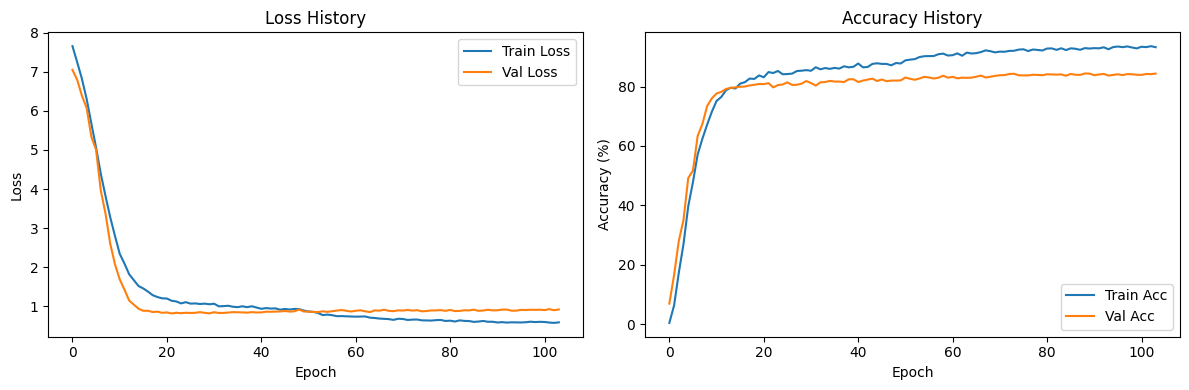


Performing detailed evaluation...

=== Detailed Subfamily Classification Report ===
----------------------------------------------------------------------------------------------------

Subfamily: 1.C.111.1
Total Size: 18 members
Data Split: 18 members (80% training, 20% testing)

Training Set Statistics:
  - Number of training proteins: 14

Testing Set Statistics:
  - Number of test proteins: 4
  - Correct predictions: 4
  - Accuracy: 100.00%
----------------------------------------------------------------------------------------------------

Subfamily: 1.E.14.1
Total Size: 17 members
Data Split: 17 members (80% training, 20% testing)

Training Set Statistics:
  - Number of training proteins: 13

Testing Set Statistics:
  - Number of test proteins: 4
  - Correct predictions: 4
  - Accuracy: 100.00%
----------------------------------------------------------------------------------------------------

Subfamily: 2.A.127.1
Total Size: 17 members
Data Split: 17 members (80% training, 20% 

In [4]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import WeightedRandomSampler
from collections import defaultdict
from scipy.special import softmax

# Load data
old_data = r'c:\Users\11944\Desktop\protein_cal\data_source\data_old.csv'
df = pd.read_csv(old_data)

class ProteinDataset(Dataset):
    def __init__(self, df, max_domains=50):
        self.max_domains = max_domains
        
        # Convert string representations of lists to actual lists
        df['Domains'] = df['Domains'].apply(ast.literal_eval)
        df['Seperator'] = df['Seperator'].apply(ast.literal_eval)
        
        # Create label encoder for subfamilies
        self.label_encoder = LabelEncoder()
        encoded_labels = self.label_encoder.fit_transform(df['Subfamily'])
        
        # Process features
        self.features = []
        self.labels = []
        
        # Get unique domain accessions for one-hot encoding
        all_domains = set()
        for row in df['Domains']:
            for domain in row:
                domain_acc = domain[0].split(':')[1]  # Get numeric part of CDD:XXXXX
                all_domains.add(domain_acc)
        self.domain_vocab = {acc: idx for idx, acc in enumerate(sorted(all_domains))}
        
        for _, row in df.iterrows():
            # Sort domains by start position to maintain order
            domains = sorted(row['Domains'], key=lambda x: x[1])
            
            # Initialize features
            domain_features = []
            
            # 1. Domain presence and position features
            domain_presence = np.zeros(len(self.domain_vocab))
            domain_positions = np.zeros((len(self.domain_vocab), 2))  # start and end positions
            domain_scores = np.zeros(len(self.domain_vocab))
            
            # 2. Domain order features
            ordered_domains = []
            
            # 3. Domain transition features
            transitions = []
            
            # Process each domain
            prev_domain = None
            for i, domain in enumerate(domains):
                domain_acc = domain[0].split(':')[1]
                domain_idx = self.domain_vocab[domain_acc]
                
                # Update domain presence
                domain_presence[domain_idx] = 1
                
                # Update position features (normalized by protein length)
                domain_positions[domain_idx] = [
                    domain[1] / row['Protein length'],
                    domain[2] / row['Protein length']
                ]
                
                # Update domain scores (normalized)
                domain_scores[domain_idx] = np.log1p(domain[3])  # Log transform scores
                
                # Add to ordered domains
                ordered_domains.append(domain_idx)
                
                # Add transition if not first domain
                if prev_domain is not None:
                    transition = (prev_domain, domain_idx)
                    transitions.append(transition)
                prev_domain = domain_idx
            
            # 4. Process separators
            separator_features = []
            for sep in row['Seperator']:
                # Normalize positions by protein length
                start_norm = sep[1] / row['Protein length']
                end_norm = sep[2] / row['Protein length']
                length_norm = (end_norm - start_norm)
                separator_features.extend([start_norm, end_norm, length_norm])
            
            # Pad separator features
            separator_features = (separator_features + [0] * 60)[:60]  # Max 20 separators * 3 features
            
            # 5. Create final feature vector
            feature_vector = np.concatenate([
                domain_presence,  # Domain presence
                domain_positions.flatten(),  # Domain positions
                domain_scores,  # Domain scores
                np.array(separator_features)  # Separator features
            ])
            
            # Add order features
            order_features = np.zeros(self.max_domains)
            for i, domain_idx in enumerate(ordered_domains[:self.max_domains]):
                order_features[i] = domain_idx
            
            # Add domain count feature
            domain_count = len(domains) / self.max_domains  # Normalized domain count
            
            # Combine all features
            final_features = np.concatenate([
                feature_vector, 
                order_features,
                [domain_count]
            ])
            
            self.features.append(final_features)
            self.labels.append(encoded_labels[_])
        
        # Convert to tensors and normalize features
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)
        
        # Normalize features
        self.feature_mean = self.features.mean(dim=0)
        self.feature_std = self.features.std(dim=0)
        self.feature_std[self.feature_std == 0] = 1  # Avoid division by zero
        self.features = (self.features - self.feature_mean) / self.feature_std
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'label': self.labels[idx]
        }

class ImprovedProteinClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[512, 256, 128]):
        super(ImprovedProteinClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.4)
            ])
            prev_dim = hidden_dim
        
        self.feature_layers = nn.Sequential(*layers)
        
        # Final classification layer
        self.classifier = nn.Linear(hidden_dims[-1], num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        features = self.feature_layers(x)
        output = self.classifier(features)
        return output

def analyze_misclassification_type(true_subfamily, pred_subfamily):
    """
    Analyze if misclassification is within same family or different family
    Returns: 'same_family' or 'different_family'
    """
    true_family = '.'.join(true_subfamily.split('.')[:3])
    pred_family = '.'.join(pred_subfamily.split('.')[:3])
    
    if true_family == pred_family:
        return 'same_family'
    return 'different_family'

def custom_split_dataset(df):
    """
    Implements custom splitting strategy based on subfamily size:
    - 1 member: put in both train and test
    - 2 members: split 1:1
    - >2 members: split 80:20
    """
    train_indices = []
    test_indices = []
    
    # Group by subfamily to handle each case
    for subfamily, group in df.groupby('Subfamily'):
        indices = group.index.tolist()
        n_samples = len(indices)
        
        if n_samples == 1:
            # Case 1: Single member goes to both sets
            train_indices.extend(indices)
            test_indices.extend(indices)
        elif n_samples == 2:
            # Case 2: Split 1:1
            train_indices.append(indices[0])
            test_indices.append(indices[1])
        else:
            # Case 3: Split 80:20
            n_train = int(0.8 * n_samples)
            train_indices.extend(indices[:n_train])
            test_indices.extend(indices[n_train:])
    
    return train_indices, test_indices

def evaluate_model_detailed(model, data_loader, dataset, device, original_df, train_indices):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    protein_ids = []
    subfamily_metrics = defaultdict(lambda: {
        'train_count': 0,
        'test_count': 0,
        'correct': 0,
        'size': 0,  # Total size of subfamily
        'misclassified': [],
        'same_family_errors': 0,
        'different_family_errors': 0
    })
    
    # Calculate total size of each subfamily
    subfamily_counts = original_df['Subfamily'].value_counts()
    for subfamily, count in subfamily_counts.items():
        subfamily_metrics[subfamily]['size'] = count
    
    # Count training samples
    for idx in train_indices:
        subfamily = original_df.iloc[idx]['Subfamily']
        subfamily_metrics[subfamily]['train_count'] += 1
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            features = batch['features'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(features)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probs, dim=1)
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(confidence.cpu().numpy())
            
            if hasattr(data_loader.dataset, 'indices'):
                batch_indices = data_loader.dataset.indices[i*data_loader.batch_size:
                                                          (i+1)*data_loader.batch_size]
            else:
                batch_indices = list(range(i*data_loader.batch_size,
                                         (i+1)*data_loader.batch_size))
            protein_ids.extend(original_df.iloc[batch_indices]['Protein'].values)
    
    true_subfamilies = dataset.label_encoder.inverse_transform(true_labels)
    pred_subfamilies = dataset.label_encoder.inverse_transform(predictions)
    
    results_df = pd.DataFrame({
        'Protein': protein_ids,
        'True_Subfamily': true_subfamilies,
        'Predicted_Subfamily': pred_subfamilies,
        'Confidence': confidences
    })
    
    # Calculate metrics
    for idx, row in results_df.iterrows():
        true_sf = row['True_Subfamily']
        pred_sf = row['Predicted_Subfamily']
        subfamily_metrics[true_sf]['test_count'] += 1
        
        if true_sf == pred_sf:
            subfamily_metrics[true_sf]['correct'] += 1
        else:
            error_type = analyze_misclassification_type(true_sf, pred_sf)
            if error_type == 'same_family':
                subfamily_metrics[true_sf]['same_family_errors'] += 1
            else:
                subfamily_metrics[true_sf]['different_family_errors'] += 1
                
            subfamily_metrics[true_sf]['misclassified'].append({
                'Protein': row['Protein'],
                'Predicted_as': pred_sf,
                'Confidence': row['Confidence'],
                'Error_Type': error_type
            })
    
    # Create detailed report
    subfamily_report = {}
    for subfamily, metrics in subfamily_metrics.items():
        test_count = metrics['test_count']
        correct = metrics['correct']
        accuracy = (correct / test_count * 100) if test_count > 0 else 0
        
        subfamily_report[subfamily] = {
            'Size': metrics['size'],
            'Train_Samples': metrics['train_count'],
            'Test_Samples': test_count,
            'Correct_Predictions': correct,
            'Accuracy': accuracy,
            'Same_Family_Errors': metrics['same_family_errors'],
            'Different_Family_Errors': metrics['different_family_errors'],
            'Misclassified_Details': metrics['misclassified']
        }
    
    return subfamily_report, results_df

# Create dataset
dataset = ProteinDataset(df)

# Use custom split
train_indices, test_indices = custom_split_dataset(df)

# Create custom subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, test_indices)

# Calculate class weights for loss function
all_labels = dataset.labels.numpy()
unique_labels, label_counts = np.unique(all_labels, return_counts=True)
class_weights = 1. / label_counts
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = torch.FloatTensor(class_weights)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = dataset.features.shape[1]
model = ImprovedProteinClassifier(
    input_dim=input_dim,
    num_classes=len(dataset.label_encoder.classes_),
    hidden_dims=[512, 256, 128]
).to(device)

# Use weighted loss for imbalanced classes
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Training loop with early stopping and time tracking
num_epochs = 200
best_val_acc = 0
patience = 15
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_loader:
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # L2 regularization
        l2_lambda = 0.001
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            features = batch['features'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total
    
    # Update learning rate
    scheduler.step(val_acc)
    
    # Record history
    history['train_loss'].append(train_loss/len(train_loader))
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss/len(val_loader))
    history['val_acc'].append(val_acc)
    
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_duration:.2f}s')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    
    # Save best model and check early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'best_protein_classifier.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f}s')

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Load best model for evaluation
checkpoint = torch.load('best_protein_classifier.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Detailed evaluation
print("\nPerforming detailed evaluation...")
subfamily_report, results_df = evaluate_model_detailed(model, val_loader, dataset, device, df, train_indices)

# After the evaluation part, modify the printing section:

from tabulate import tabulate

print("\n=== Detailed Subfamily Classification Report ===")
print("-" * 100)

# Store different family errors for later reporting
different_family_errors_list = []

for subfamily, metrics in subfamily_report.items():
    total_size = metrics['Size']
    print(f"\nSubfamily: {subfamily}")
    print(f"Total Size: {total_size} members")
    
    # Print data split information based on size
    if total_size == 1:
        print("Data Split: Single member (used in both training and testing)")
    elif total_size == 2:
        print("Data Split: Two members (1 for training, 1 for testing)")
    else:
        print(f"Data Split: {total_size} members (80% training, 20% testing)")
    
    print("\nTraining Set Statistics:")
    print(f"  - Number of training proteins: {metrics['Train_Samples']}")
    
    print("\nTesting Set Statistics:")
    print(f"  - Number of test proteins: {metrics['Test_Samples']}")
    print(f"  - Correct predictions: {metrics['Correct_Predictions']}")
    print(f"  - Accuracy: {metrics['Accuracy']:.2f}%")
    
    misclassified_count = len(metrics['Misclassified_Details'])
    if misclassified_count > 0:
        print("\nMisclassification Analysis:")
        print(f"  - Total misclassifications: {misclassified_count}")
        print(f"  - Same family errors: {metrics['Same_Family_Errors']}")
        print(f"  - Different family errors: {metrics['Different_Family_Errors']}")
        
        print("\nMisclassified Proteins Details:")
        for misc in metrics['Misclassified_Details']:
            print(f"  - Protein: {misc['Protein']}")
            print(f"    Predicted as: {misc['Predicted_as']}")
            print(f"    Confidence: {misc['Confidence']:.4f}")
            print(f"    Error Type: {misc['Error_Type']}")
            
            # Collect different family errors
            if misc['Error_Type'] == 'different_family':
                different_family_errors_list.append({
                    'True_Subfamily': subfamily,
                    'Protein': misc['Protein'],
                    'Predicted_as': misc['Predicted_as'],
                    'Confidence': misc['Confidence']
                })
    print("-" * 100)

# Calculate statistics
total_test = sum(m['Test_Samples'] for m in subfamily_report.values())
total_correct = sum(m['Correct_Predictions'] for m in subfamily_report.values())
total_misclassifications = sum(len(m['Misclassified_Details']) for m in subfamily_report.values())
total_same_family_errors = sum(m['Same_Family_Errors'] for m in subfamily_report.values())
total_different_family_errors = sum(m['Different_Family_Errors'] for m in subfamily_report.values())

# Initialize counters for family analysis
perfect_accuracy_single_subfamily = defaultdict(int)
perfect_accuracy_multi_subfamily = defaultdict(int)
imperfect_accuracy_single_subfamily = defaultdict(int)
imperfect_accuracy_multi_subfamily = defaultdict(int)
all_families = set()

# Create a mapping of subfamilies to their families
subfamily_to_family = {}
for subfamily in subfamily_report.keys():
    family = '.'.join(subfamily.split('.')[:3])
    subfamily_to_family[subfamily] = family
    all_families.add(family)

# Count subfamilies per family
family_subfamily_count = defaultdict(int)
for subfamily in subfamily_report.keys():
    family = subfamily_to_family[subfamily]
    family_subfamily_count[family] += 1

# Analyze families based on accuracy and subfamily count
for subfamily, metrics in subfamily_report.items():
    family = subfamily_to_family[subfamily]
    accuracy = metrics['Accuracy']
    
    if accuracy == 100.0:
        if family_subfamily_count[family] == 1:
            perfect_accuracy_single_subfamily[family] += 1
        else:
            perfect_accuracy_multi_subfamily[family] += 1
    else:
        if family_subfamily_count[family] == 1:
            imperfect_accuracy_single_subfamily[family] += 1
        else:
            imperfect_accuracy_multi_subfamily[family] = family_subfamily_count[family]

print("\n=== Overall Classification Statistics ===")
classification_stats = [
    ["Total Test Proteins", total_test],
    ["Total Correct Predictions", total_correct],
    ["Overall Accuracy", f"{(total_correct/total_test*100):.2f}%"]
]
print(tabulate(classification_stats, headers=["Metric", "Value"], tablefmt="grid"))

print("\n=== Misclassification Statistics ===")
if total_misclassifications > 0:
    misclassification_stats = [
        ["Total Misclassifications", total_misclassifications, "100%"],
        ["Same Family Errors", total_same_family_errors, f"{(total_same_family_errors/total_misclassifications*100):.2f}%"],
        ["Different Family Errors", total_different_family_errors, f"{(total_different_family_errors/total_misclassifications*100):.2f}%"]
    ]
    print(tabulate(misclassification_stats, headers=["Error Type", "Count", "Percentage"], tablefmt="grid"))

print("\n=== Family Analysis Statistics ===")
family_stats = [
    ["Total Number of Families", len(all_families), "100%"],
    ["Families with Single Subfamily (100% Accuracy)", len(perfect_accuracy_single_subfamily), f"{(len(perfect_accuracy_single_subfamily)/len(all_families)*100):.2f}%"],
    ["Families with Single Subfamily (<100% Accuracy)", len(imperfect_accuracy_single_subfamily), f"{(len(imperfect_accuracy_single_subfamily)/len(all_families)*100):.2f}%"],
    ["Families with Multiple Subfamilies (100% Accuracy)", len(perfect_accuracy_multi_subfamily), f"{(len(perfect_accuracy_multi_subfamily)/len(all_families)*100):.2f}%"],
    ["Families with Multiple Subfamilies (<100% Accuracy)", len(imperfect_accuracy_multi_subfamily), f"{(len(imperfect_accuracy_multi_subfamily)/len(all_families)*100):.2f}%"]
]
print(tabulate(family_stats, headers=["Category", "Count", "Percentage"], tablefmt="grid"))

# Verification of total
total_categorized = (len(perfect_accuracy_single_subfamily) + 
                    len(imperfect_accuracy_single_subfamily) + 
                    len(perfect_accuracy_multi_subfamily) + 
                    len(imperfect_accuracy_multi_subfamily))
if total_categorized != len(all_families):
    print("\nWarning: Family categorization sum doesn't match total families!")
    print(f"Total families: {len(all_families)}, Sum of categories: {total_categorized}")

print("\n=== Different Family Error Details ===")
if different_family_errors_list:
    error_details = [[error['True_Subfamily'], 
                     error['Protein'], 
                     error['Predicted_as'], 
                     f"{error['Confidence']:.4f}"] 
                    for error in different_family_errors_list]
    print(tabulate(error_details, 
                  headers=["True Subfamily", "Protein", "Predicted As", "Confidence"], 
                  tablefmt="grid"))
else:
    print("No different family errors found.")

print("-" * 100)

# Save detailed results to CSV
results_df.to_csv('detailed_classification_results.csv', index=False)

In [ ]:
import torch

# Check PyTorch version
pytorch_version = torch.__version__
print(f"PyTorch version: {pytorch_version}")

# Check CUDA version
cuda_version = torch.version.cuda
print(f"CUDA version: {cuda_version}")

PyTorch version: 2.7.0+cu128
CUDA version: 12.8


In [2]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import WeightedRandomSampler
from collections import defaultdict
from scipy.special import softmax

# Load data
df = pd.read_csv("output_real.csv")

class ProteinDataset(Dataset):
    def __init__(self, df, max_domains=50):
        self.max_domains = max_domains
        
        # Convert string representations of lists to actual lists
        df['Domains'] = df['Domains'].apply(ast.literal_eval)
        df['Seperator'] = df['Seperator'].apply(ast.literal_eval)
        
        # Create label encoder for subfamilies
        self.label_encoder = LabelEncoder()
        encoded_labels = self.label_encoder.fit_transform(df['Subfamily'])
        
        # Process features
        self.features = []
        self.labels = []
        
        # Get unique domain accessions for one-hot encoding
        all_domains = set()
        for row in df['Domains']:
            for domain in row:
                domain_acc = domain[0].split(':')[1]  # Get numeric part of CDD:XXXXX
                all_domains.add(domain_acc)
        self.domain_vocab = {acc: idx for idx, acc in enumerate(sorted(all_domains))}
        
        for _, row in df.iterrows():
            # Sort domains by start position to maintain order
            domains = sorted(row['Domains'], key=lambda x: x[1])
            
            # Initialize features
            domain_features = []
            
            # 1. Domain presence and position features
            domain_presence = np.zeros(len(self.domain_vocab))
            domain_positions = np.zeros((len(self.domain_vocab), 2))  # start and end positions
            domain_scores = np.zeros(len(self.domain_vocab))
            
            # 2. Domain order features
            ordered_domains = []
            
            # 3. Domain transition features
            transitions = []
            
            # Process each domain
            prev_domain = None
            for i, domain in enumerate(domains):
                domain_acc = domain[0].split(':')[1]
                domain_idx = self.domain_vocab[domain_acc]
                
                # Update domain presence
                domain_presence[domain_idx] = 1
                
                # Update position features (normalized by protein length)
                domain_positions[domain_idx] = [
                    domain[1] / row['Protein length'],
                    domain[2] / row['Protein length']
                ]
                
                # Update domain scores (normalized)
                domain_scores[domain_idx] = np.log1p(domain[3])  # Log transform scores
                
                # Add to ordered domains
                ordered_domains.append(domain_idx)
                
                # Add transition if not first domain
                if prev_domain is not None:
                    transition = (prev_domain, domain_idx)
                    transitions.append(transition)
                prev_domain = domain_idx
            
            # 4. Process separators
            separator_features = []
            for sep in row['Seperator']:
                # Normalize positions by protein length
                start_norm = sep[1] / row['Protein length']
                end_norm = sep[2] / row['Protein length']
                length_norm = (end_norm - start_norm)
                separator_features.extend([start_norm, end_norm, length_norm])
            
            # Pad separator features
            separator_features = (separator_features + [0] * 60)[:60]  # Max 20 separators * 3 features
            
            # 5. Create final feature vector
            feature_vector = np.concatenate([
                domain_presence,  # Domain presence
                domain_positions.flatten(),  # Domain positions
                domain_scores,  # Domain scores
                np.array(separator_features)  # Separator features
            ])
            
            # Add order features
            order_features = np.zeros(self.max_domains)
            for i, domain_idx in enumerate(ordered_domains[:self.max_domains]):
                order_features[i] = domain_idx
            
            # Add domain count feature
            domain_count = len(domains) / self.max_domains  # Normalized domain count
            
            # Combine all features
            final_features = np.concatenate([
                feature_vector, 
                order_features,
                [domain_count]
            ])
            
            self.features.append(final_features)
            self.labels.append(encoded_labels[_])
        
        # Convert to tensors and normalize features
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)
        
        # Normalize features
        self.feature_mean = self.features.mean(dim=0)
        self.feature_std = self.features.std(dim=0)
        self.feature_std[self.feature_std == 0] = 1  # Avoid division by zero
        self.features = (self.features - self.feature_mean) / self.feature_std
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'label': self.labels[idx]
        }

class ImprovedProteinClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[512, 256, 128]):
        super(ImprovedProteinClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(0.4)
            ])
            prev_dim = hidden_dim
        
        self.feature_layers = nn.Sequential(*layers)
        
        # Final classification layer
        self.classifier = nn.Linear(hidden_dims[-1], num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        features = self.feature_layers(x)
        output = self.classifier(features)
        return output

def analyze_misclassification_type(true_subfamily, pred_subfamily):
    """
    Analyze if misclassification is within same family or different family
    Returns: 'same_family' or 'different_family'
    """
    true_family = '.'.join(true_subfamily.split('.')[:3])
    pred_family = '.'.join(pred_subfamily.split('.')[:3])
    
    if true_family == pred_family:
        return 'same_family'
    return 'different_family'

def custom_split_dataset(df):
    """
    Implements custom splitting strategy based on subfamily size:
    - 1 member: put in both train and test
    - 2 members: split 1:1
    - >2 members: split 80:20
    """
    train_indices = []
    test_indices = []
    
    # Group by subfamily to handle each case
    for subfamily, group in df.groupby('Subfamily'):
        indices = group.index.tolist()
        n_samples = len(indices)
        
        if n_samples == 1:
            # Case 1: Single member goes to both sets
            train_indices.extend(indices)
            test_indices.extend(indices)
        elif n_samples == 2:
            # Case 2: Split 1:1
            train_indices.append(indices[0])
            test_indices.append(indices[1])
        else:
            # Case 3: Split 80:20
            n_train = int(0.8 * n_samples)
            train_indices.extend(indices[:n_train])
            test_indices.extend(indices[n_train:])
    
    return train_indices, test_indices

def evaluate_model_detailed(model, data_loader, dataset, device, original_df, train_indices):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    protein_ids = []
    subfamily_metrics = defaultdict(lambda: {
        'train_count': 0,
        'test_count': 0,
        'correct': 0,
        'size': 0,  # Total size of subfamily
        'misclassified': [],
        'same_family_errors': 0,
        'different_family_errors': 0
    })
    
    # Calculate total size of each subfamily
    subfamily_counts = original_df['Subfamily'].value_counts()
    for subfamily, count in subfamily_counts.items():
        subfamily_metrics[subfamily]['size'] = count
    
    # Count training samples
    for idx in train_indices:
        subfamily = original_df.iloc[idx]['Subfamily']
        subfamily_metrics[subfamily]['train_count'] += 1
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            features = batch['features'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(features)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probs, dim=1)
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(confidence.cpu().numpy())
            
            if hasattr(data_loader.dataset, 'indices'):
                batch_indices = data_loader.dataset.indices[i*data_loader.batch_size:
                                                          (i+1)*data_loader.batch_size]
            else:
                batch_indices = list(range(i*data_loader.batch_size,
                                         (i+1)*data_loader.batch_size))
            protein_ids.extend(original_df.iloc[batch_indices]['Protein'].values)
    
    true_subfamilies = dataset.label_encoder.inverse_transform(true_labels)
    pred_subfamilies = dataset.label_encoder.inverse_transform(predictions)
    
    results_df = pd.DataFrame({
        'Protein': protein_ids,
        'True_Subfamily': true_subfamilies,
        'Predicted_Subfamily': pred_subfamilies,
        'Confidence': confidences
    })
    
    # Calculate metrics
    for idx, row in results_df.iterrows():
        true_sf = row['True_Subfamily']
        pred_sf = row['Predicted_Subfamily']
        subfamily_metrics[true_sf]['test_count'] += 1
        
        if true_sf == pred_sf:
            subfamily_metrics[true_sf]['correct'] += 1
        else:
            error_type = analyze_misclassification_type(true_sf, pred_sf)
            if error_type == 'same_family':
                subfamily_metrics[true_sf]['same_family_errors'] += 1
            else:
                subfamily_metrics[true_sf]['different_family_errors'] += 1
                
            subfamily_metrics[true_sf]['misclassified'].append({
                'Protein': row['Protein'],
                'Predicted_as': pred_sf,
                'Confidence': row['Confidence'],
                'Error_Type': error_type
            })
    
    # Create detailed report
    subfamily_report = {}
    for subfamily, metrics in subfamily_metrics.items():
        test_count = metrics['test_count']
        correct = metrics['correct']
        accuracy = (correct / test_count * 100) if test_count > 0 else 0
        
        subfamily_report[subfamily] = {
            'Size': metrics['size'],
            'Train_Samples': metrics['train_count'],
            'Test_Samples': test_count,
            'Correct_Predictions': correct,
            'Accuracy': accuracy,
            'Same_Family_Errors': metrics['same_family_errors'],
            'Different_Family_Errors': metrics['different_family_errors'],
            'Misclassified_Details': metrics['misclassified']
        }
    
    return subfamily_report, results_df

# Create dataset
dataset = ProteinDataset(df)

# Use custom split
train_indices, test_indices = custom_split_dataset(df)

# Create custom subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, test_indices)

# Calculate class weights for loss function
all_labels = dataset.labels.numpy()
unique_labels, label_counts = np.unique(all_labels, return_counts=True)
class_weights = 1. / label_counts
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = torch.FloatTensor(class_weights)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = dataset.features.shape[1]
model = ImprovedProteinClassifier(
    input_dim=input_dim,
    num_classes=len(dataset.label_encoder.classes_),
    hidden_dims=[512, 256, 128]
).to(device)

# Use weighted loss for imbalanced classes
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Training loop with early stopping and time tracking
num_epochs = 200
best_val_acc = 0
patience = 15
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch in train_loader:
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # L2 regularization
        l2_lambda = 0.001
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            features = batch['features'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total
    
    # Update learning rate
    scheduler.step(val_acc)
    
    # Record history
    history['train_loss'].append(train_loss/len(train_loader))
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss/len(val_loader))
    history['val_acc'].append(val_acc)
    
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_duration:.2f}s')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    
    # Save best model and check early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'best_protein_classifier.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f}s')

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Load best model for evaluation
checkpoint = torch.load('best_protein_classifier.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Detailed evaluation
print("\nPerforming detailed evaluation...")
subfamily_report, results_df = evaluate_model_detailed(model, val_loader, dataset, device, df, train_indices)

# After the evaluation part, modify the printing section:

from tabulate import tabulate

print("\n=== Detailed Subfamily Classification Report ===")
print("-" * 100)

# Store different family errors for later reporting
different_family_errors_list = []

for subfamily, metrics in subfamily_report.items():
    total_size = metrics['Size']
    print(f"\nSubfamily: {subfamily}")
    print(f"Total Size: {total_size} members")
    
    # Print data split information based on size
    if total_size == 1:
        print("Data Split: Single member (used in both training and testing)")
    elif total_size == 2:
        print("Data Split: Two members (1 for training, 1 for testing)")
    else:
        print(f"Data Split: {total_size} members (80% training, 20% testing)")
    
    print("\nTraining Set Statistics:")
    print(f"  - Number of training proteins: {metrics['Train_Samples']}")
    
    print("\nTesting Set Statistics:")
    print(f"  - Number of test proteins: {metrics['Test_Samples']}")
    print(f"  - Correct predictions: {metrics['Correct_Predictions']}")
    print(f"  - Accuracy: {metrics['Accuracy']:.2f}%")
    
    misclassified_count = len(metrics['Misclassified_Details'])
    if misclassified_count > 0:
        print("\nMisclassification Analysis:")
        print(f"  - Total misclassifications: {misclassified_count}")
        print(f"  - Same family errors: {metrics['Same_Family_Errors']}")
        print(f"  - Different family errors: {metrics['Different_Family_Errors']}")
        
        print("\nMisclassified Proteins Details:")
        for misc in metrics['Misclassified_Details']:
            print(f"  - Protein: {misc['Protein']}")
            print(f"    Predicted as: {misc['Predicted_as']}")
            print(f"    Confidence: {misc['Confidence']:.4f}")
            print(f"    Error Type: {misc['Error_Type']}")
            
            # Collect different family errors
            if misc['Error_Type'] == 'different_family':
                different_family_errors_list.append({
                    'True_Subfamily': subfamily,
                    'Protein': misc['Protein'],
                    'Predicted_as': misc['Predicted_as'],
                    'Confidence': misc['Confidence']
                })
    print("-" * 100)

# Calculate statistics
total_test = sum(m['Test_Samples'] for m in subfamily_report.values())
total_correct = sum(m['Correct_Predictions'] for m in subfamily_report.values())
total_misclassifications = sum(len(m['Misclassified_Details']) for m in subfamily_report.values())
total_same_family_errors = sum(m['Same_Family_Errors'] for m in subfamily_report.values())
total_different_family_errors = sum(m['Different_Family_Errors'] for m in subfamily_report.values())

# Initialize counters for family analysis
perfect_accuracy_single_subfamily = defaultdict(int)
perfect_accuracy_multi_subfamily = defaultdict(int)
imperfect_accuracy_single_subfamily = defaultdict(int)
imperfect_accuracy_multi_subfamily = defaultdict(int)
all_families = set()

# Create a mapping of subfamilies to their families
subfamily_to_family = {}
for subfamily in subfamily_report.keys():
    family = '.'.join(subfamily.split('.')[:3])
    subfamily_to_family[subfamily] = family
    all_families.add(family)

# Count subfamilies per family
family_subfamily_count = defaultdict(int)
for subfamily in subfamily_report.keys():
    family = subfamily_to_family[subfamily]
    family_subfamily_count[family] += 1

# Analyze families based on accuracy and subfamily count
for subfamily, metrics in subfamily_report.items():
    family = subfamily_to_family[subfamily]
    accuracy = metrics['Accuracy']
    
    if accuracy == 100.0:
        if family_subfamily_count[family] == 1:
            perfect_accuracy_single_subfamily[family] += 1
        else:
            perfect_accuracy_multi_subfamily[family] += 1
    else:
        if family_subfamily_count[family] == 1:
            imperfect_accuracy_single_subfamily[family] += 1
        else:
            imperfect_accuracy_multi_subfamily[family] = family_subfamily_count[family]

print("\n=== Overall Classification Statistics ===")
classification_stats = [
    ["Total Test Proteins", total_test],
    ["Total Correct Predictions", total_correct],
    ["Overall Accuracy", f"{(total_correct/total_test*100):.2f}%"]
]
print(tabulate(classification_stats, headers=["Metric", "Value"], tablefmt="grid"))

print("\n=== Misclassification Statistics ===")
if total_misclassifications > 0:
    misclassification_stats = [
        ["Total Misclassifications", total_misclassifications, "100%"],
        ["Same Family Errors", total_same_family_errors, f"{(total_same_family_errors/total_misclassifications*100):.2f}%"],
        ["Different Family Errors", total_different_family_errors, f"{(total_different_family_errors/total_misclassifications*100):.2f}%"]
    ]
    print(tabulate(misclassification_stats, headers=["Error Type", "Count", "Percentage"], tablefmt="grid"))

print("\n=== Family Analysis Statistics ===")
family_stats = [
    ["Total Number of Families", len(all_families), "100%"],
    ["Families with Single Subfamily (100% Accuracy)", len(perfect_accuracy_single_subfamily), f"{(len(perfect_accuracy_single_subfamily)/len(all_families)*100):.2f}%"],
    ["Families with Single Subfamily (<100% Accuracy)", len(imperfect_accuracy_single_subfamily), f"{(len(imperfect_accuracy_single_subfamily)/len(all_families)*100):.2f}%"],
    ["Families with Multiple Subfamilies (100% Accuracy)", len(perfect_accuracy_multi_subfamily), f"{(len(perfect_accuracy_multi_subfamily)/len(all_families)*100):.2f}%"],
    ["Families with Multiple Subfamilies (<100% Accuracy)", len(imperfect_accuracy_multi_subfamily), f"{(len(imperfect_accuracy_multi_subfamily)/len(all_families)*100):.2f}%"]
]
print(tabulate(family_stats, headers=["Category", "Count", "Percentage"], tablefmt="grid"))

# Verification of total
total_categorized = (len(perfect_accuracy_single_subfamily) + 
                    len(imperfect_accuracy_single_subfamily) + 
                    len(perfect_accuracy_multi_subfamily) + 
                    len(imperfect_accuracy_multi_subfamily))
if total_categorized != len(all_families):
    print("\nWarning: Family categorization sum doesn't match total families!")
    print(f"Total families: {len(all_families)}, Sum of categories: {total_categorized}")

print("\n=== Different Family Error Details ===")
if different_family_errors_list:
    error_details = [[error['True_Subfamily'], 
                     error['Protein'], 
                     error['Predicted_as'], 
                     f"{error['Confidence']:.4f}"] 
                    for error in different_family_errors_list]
    print(tabulate(error_details, 
                  headers=["True Subfamily", "Protein", "Predicted As", "Confidence"], 
                  tablefmt="grid"))
else:
    print("No different family errors found.")

print("-" * 100)

# Save detailed results to CSV
results_df.to_csv('detailed_classification_results.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'output_real.csv'

In [5]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import WeightedRandomSampler
from collections import defaultdict
from scipy.special import softmax

df = pd.read_csv("data_source/data_old.csv")

In [6]:
df

,Protein,Protein length,Family,Subfamily,Domains,Seperator
0,A4GCL7,90,1.A.102,1.A.102.1,"[('CDD:288812', 1, 87, 149.0)]",[]
1,AXH81214,57,1.A.102,1.A.102.1,"[('CDD:288812', 1, 56, 57.8)]",[]
2,AJD12486,57,1.A.102,1.A.102.1,"[('CDD:288812', 1, 56, 58.9)]",[]
3,AFH41240,90,1.A.102,1.A.102.1,"[('CDD:288812', 1, 86, 117.0)]",[]
4,P76298,692,1.A.104,1.A.104.1,"[('CDD:224217', 2, 692, 1005.0), ('CDD:235672'...",[]
...,...,...,...,...,...,...
5781,Q58117,214,9.B.98,9.B.98.1,"[('CDD:224219', 10, 214, 101.0), ('CDD:426524'...",[]
5782,M0LLS9,367,9.B.98,9.B.98.1,"[('CDD:224219', 174, 352, 92.4), ('CDD:426524'...","[('BEGIN to CDD:426524', 1, 173)]"
5783,C7T873,207,9.B.98,9.B.98.1,"[('CDD:224219', 16, 206, 46.2), ('CDD:426524',...",[]
5784,WP_138772272,335,9.B.98,9.B.98.1,"[('CDD:224219', 93, 300, 112.0), ('CDD:426524'...","[('BEGIN to CDD:224219', 1, 92)]"
